In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
# import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import time as time
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

2024-06-02 18:24:36.589131: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Function Definitions

In [4]:
def find_coverage_calib(y, y_noisy, sigmas, ci, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    q_hats = []
    times = []
    errors = []
    upper_bounds = []
    lower_bounds = []
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_noisy + k[i] * sigmas
            initial_lower = y_noisy - k[i] * sigmas
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            errors.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            upper_bounds.append(upper)
            lower_bounds.append(lower)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, errors, upper_bounds, lower_bounds

In [5]:
def find_coverage_train_test(y, y_noisy, sigmas, ci, q_hats, flag=False):
    alpha = 1 - ci
    k = st.norm.ppf(1 - alpha / 2)
    coverage = np.zeros(len(ci))
    upper_bounds = []
    lower_bounds = []
    if flag == False:
        for i in range(len(ci)):
            upper = y_noisy + k[i] * sigmas
            lower = y_noisy - k[i] * sigmas
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_noisy + k[i] * sigmas + q_hats[i]
            lower = y_noisy - k[i] * sigmas - q_hats[i]
            upper_bounds.append(upper)
            lower_bounds.append(lower)
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, upper_bounds, lower_bounds

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

# Model Training

In [7]:
train = {
    2: {
        'start_time': "2013-07-01",
        'end_time': "2013-07-31"
    },
    5: {
        'start_time': "2014-07-01",
        'end_time': "2014-07-31"
    }
}
test = {
    1: {
        'start_time': "2014-07-01",
        'end_time': "2014-07-31"
    }
}
appliances = ["fridge"]

In [8]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [9]:
model = seq2point_gaussian.seq2point()

In [10]:
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

In [18]:
len(params['params']['Dense_0']['kernel'])

4950

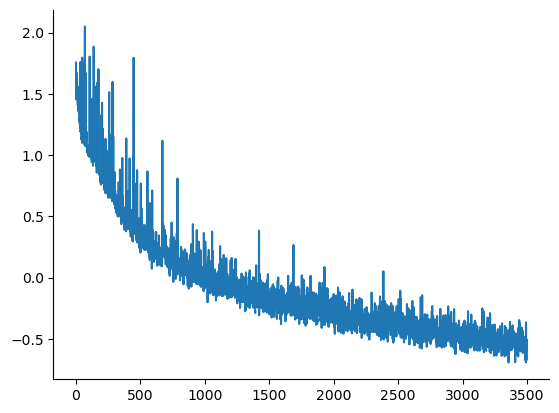

In [11]:
plt.plot(losses)
sns.despine()

# Before Calibration

##### Results on Calibration Set

In [12]:
y_hat = model.apply(params, x_cal, True, rngs={
                    "dropout": jax.random.PRNGKey(0)})

In [13]:
cal_mean = scaler_y.inverse_transform(y_hat[0])
cal_sigma = scaler_y.scale_*y_hat[1]
y_true_cal = scaler_y.inverse_transform(y_cal)

In [14]:
print(f"RMSE : {errors.rmse(y_true_cal, cal_mean):.4f} MAE  : {errors.mae(y_true_cal, cal_mean):.4f} NLL : {errors.NLL(cal_mean,cal_sigma,y_true_cal):.4f}")

RMSE : 23.0972 MAE  : 10.9896 NLL : 3.5811


##### Results on Training Set

In [15]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})

In [16]:
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [17]:
print(f"RMSE : {errors.rmse(y_train_scaled, train_mean):.4f} MAE  : {errors.mae(y_train_scaled, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_train_scaled):.4f}")

RMSE : 23.6585 MAE  : 10.5785 NLL : 3.5057


##### Results on Test Set

In [18]:
y_hat_test = model.apply(params, x_test, True, rngs={
    "dropout": jax.random.PRNGKey(0)})


In [19]:
test_mean = scaler_y.inverse_transform(y_hat_test[0])
test_sigma = scaler_y.scale_*y_hat_test[1]

In [20]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test, test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 43.5590 MAE  : 29.6563 NLL : 8.1374


# After Calibration

### Conformal Prediction

##### Results on Calibration Set

In [21]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_cal, _, _, _, _, _ = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci)

In [22]:
initial_coverages_cal

array([0.        , 0.06418709, 0.13600366, 0.22146206, 0.31359625,
       0.42248207, 0.53514123, 0.64829791, 0.7632376 , 0.88601404,
       1.        ])

In [23]:
flag = True
final_coverages_cal, q_hats, times, errors, uppers_cal, lowers_cal = find_coverage_calib(
    y_true_cal, cal_mean, cal_sigma, ci, flag=flag)

In [24]:
final_coverages_cal

array([0.        , 0.10005391, 0.20006636, 0.30007881, 0.40009123,
       0.50006223, 0.60007465, 0.70004565, 0.80005807, 0.90011197,
       1.        ])

In [25]:
q_hats

[0,
 0.49650574,
 0.7134628,
 0.7965698,
 0.74503326,
 0.6550026,
 0.5303402,
 0.4008931,
 0.2547108,
 0.15195465,
 0]

In [26]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)

In [27]:
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.5095780938863754 and ece error is 0.046325281262397766
Final ace error is 0.0006428658962249478 and ece error is 5.844235420226799e-05


##### Results on Training Set

In [28]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_train, _, _, _ = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, [])
initial_coverages_train

array([0.        , 0.06957748, 0.14259651, 0.2297826 , 0.32766652,
       0.43760279, 0.55503035, 0.66981798, 0.78130227, 0.89792818,
       1.        ])

In [29]:
q_hats

[0,
 0.49650574,
 0.7134628,
 0.7965698,
 0.74503326,
 0.6550026,
 0.5303402,
 0.4008931,
 0.2547108,
 0.15195465,
 0]

In [30]:
flag = True
final_coverages_train, q_hats, uppers_train, lowers_train = find_coverage_train_test(
    y_train_scaled, train_mean, train_sigma, ci, q_hats, flag=flag)
print(final_coverages_train)

[0.         0.10496054 0.20519413 0.31124657 0.41590303 0.52141643
 0.62386143 0.72225678 0.81510967 0.91280013 1.        ]


In [31]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)

In [32]:
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.3886953219771385 and ece error is 0.035335938361558045
Final ace error is 0.1327487155795097 and ece error is 0.012068065052682701


##### Results on Test Set

In [33]:
ci = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
initial_coverages_test, _, _, _ = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, [])
initial_coverages_test

array([0.        , 0.01813827, 0.03621268, 0.05942839, 0.09184097,
       0.13479163, 0.19179307, 0.26188728, 0.35369632, 0.47747084,
       1.        ])

In [34]:
q_hats

[0,
 0.49650574,
 0.7134628,
 0.7965698,
 0.74503326,
 0.6550026,
 0.5303402,
 0.4008931,
 0.2547108,
 0.15195465,
 0]

In [35]:
flag = True
final_coverages_test, q_hats, uppers_test, lowers_test = find_coverage_train_test(
    y_test, test_mean, test_sigma, ci, q_hats, flag=flag)
print(final_coverages_test)

[0.         0.02337538 0.04467507 0.06932779 0.10221938 0.14609613
 0.20188408 0.27015808 0.35969982 0.48165417 1.        ]


In [36]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)

In [37]:
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Initial ace error is 2.8747405577450986 and ece error is 0.2613400507040999
Final ace error is 2.8009101059287786 and ece error is 0.2546281914480708


##### Comparison of Results

In [38]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

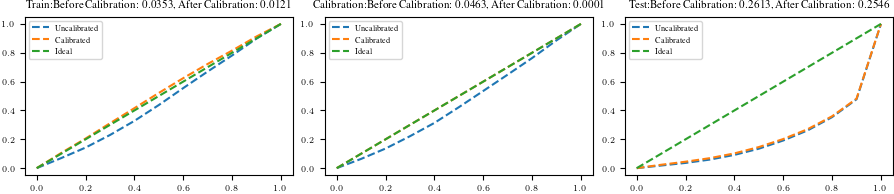

In [39]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')